In [1]:
import numpy as np
from sklearn.datasets import make_moons
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
moons = make_moons(n_samples=1000, random_state=42)

In [3]:
X = moons[0]
y= moons[1]

In [4]:
moons_df = pd.DataFrame(X, columns=['feature_0', 'feature_1'])
moons_df['class'] = y

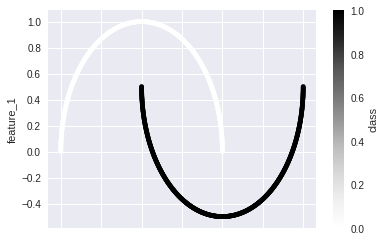

In [5]:
moons_df.plot.scatter(x='feature_0', y='feature_1', c='class')

In [6]:
class DBScanScratch:
    def __init__(self):
        self.r = None
        self.cluster_labels = None
        self.assigned_clusters = None

    
    def fit(self, X):
        all_dists = cdist(X, X)
        self.r = all_dists.mean() * 0.1 # set radius for dbscan search. make this a tunable parameter
        
        # set all observations in X to cluster == 0, i.e. unclustered
        self.assigned_clusters = np.zeros(X.shape[0])
                        
        current_cluster = 1 # start with cluster 1
        
        while np.any(self.assigned_clusters == 0): # while unclustered entries exist
#             print("working on cluster", current_cluster)
            
            # pick a random (unclustered) observation of X as starting point for the new cluster
            # seems like there should be a shortcut to do this, but this seems like the simple solution
            X_unclustered = X[self.assigned_clusters == 0]
            starting_point = X_unclustered[np.random.choice(X_unclustered.shape[0])] 
            #cdist function needs starting_point to be 2d; this is a hacky work around
            starting_point = np.array([starting_point, starting_point])
            
            bool_cluster = self.scan(X, starting_point)
            self.assigned_clusters += bool_cluster * current_cluster
            
            current_cluster += 1 # increment current cluster
            
        self.cluster_labels = np.array(set(self.assigned_clusters))
    
    def scan(self, X, working_cluster):
#         print(working_cluster.shape) # for error checking

        scan_dist = cdist(X, working_cluster) #measure distance between all X observation and clustered observations
        closest_scan = scan_dist.min(axis=1) # get shortest measured distance
        within_scan = closest_scan <= self.r # bool array of observations of X who are within r, i.e the cluster
        
        updated_working_cluster = X[within_scan]
        
        # if updated_working_cluster is different (more observations by definition)
        # check for more observations within r distance from the current cluster state
        if not np.array_equal(working_cluster, updated_working_cluster):
            within_scan = np.add(within_scan, self.scan(X, updated_working_cluster)) # recursion!
            
        return within_scan


In [7]:
dbs_scratch = DBScanScratch()

In [16]:
%%timeit
dbs_scratch.fit(X)

62.7 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
moons_df['scratch_assigned'] = dbs_scratch.assigned_clusters

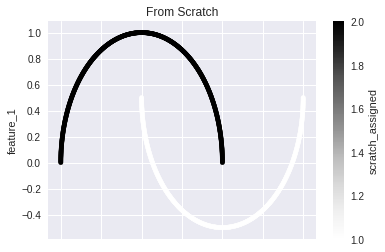

In [18]:
moons_df.plot.scatter(x='feature_0', y='feature_1', c='scratch_assigned')
plt.title('From Scratch')

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
dbs_sklearn = DBSCAN()

In [17]:
%%timeit
dbs_sklearn.fit(X)

7.63 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
moons_df['sklearn_assigned'] = dbs_sklearn.labels_

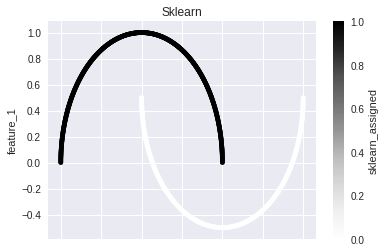

In [19]:
moons_df.plot.scatter(x='feature_0', y='feature_1', c='sklearn_assigned')
plt.title('Sklearn')